<h1 style="
  font-family: 'Glacial Indifference', sans-serif;
  font-size: 30px;
  text-align: center;
  background-color: #0F5444;
  color: white;
  border-radius: 50px 50px 0 0;
  line-height: 1.5;
  text-transform: uppercase;
  margin: 0;
  padding: 15px 20px;
">
  Logistic Regression Modeling
</h1>

# Objective
To examine how lifestyle behaviors influence the likelihood of being diagnosed with diabetes.


# 1. Setup & Imports

In [139]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_auc_score, roc_curve
# from sklearn.preprocessing import StandardScaler

In [150]:
PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / "data" /"processed"
REPORTS_DIR = PROJECT_ROOT / "reports"
FIGURES_DIR = PROJECT_ROOT / "reports" / "figures"
MODEL_DIR = PROJECT_ROOT / "models"

In [141]:
processed_data = pd.read_csv(DATA_DIR / "diabetes_lifestyle_analysis.csv")

In [142]:
processed_data.head()

,diagnosed_diabetes,smoking_status,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,age,gender,ethnicity,education_level,income_level,employment_status
0,1,Never,0,215,5.7,7.9,7.9,58,Male,Asian,Highschool,Lower-Middle,Employed
1,0,Former,1,143,6.7,6.5,8.7,48,Female,White,Highschool,Middle,Employed
2,1,Never,1,57,6.4,10.0,8.1,60,Male,Hispanic,Highschool,Middle,Unemployed
3,1,Never,0,49,3.4,6.6,5.2,74,Female,Black,Highschool,Low,Retired
4,1,Never,1,109,7.2,7.4,5.0,46,Male,White,Graduate,Middle,Retired


# 2. Define the model

For a binary outcome like `diagnosed_diabetes`, the logistic regression model is:

logit(P(Y=1)) = β<sub>0</sub> + β<sub>1</sub>X<sub>1</sub> + β<sub>2</sub>X<sub>2</sub> + ... + β<sub>k</sub>X<sub>k</sub>

Where:

- \(Y = \text{diagnosed\_diabetes}\) (0 = No, 1 = Yes)
- \(X_1, X_2, \dots, X_k\) = predictors (e.g., age, gender, smoking status, BMI, etc.)
- \(\beta_i\) = coefficients to estimate


# 3. Train the model

In [143]:
# One-hot encode categorical variables
X = pd.get_dummies(processed_data.drop(columns=['diagnosed_diabetes']), drop_first=True)
y = processed_data['diagnosed_diabetes']

# Convert back to DataFrame to keep column names
X_scaled = pd.DataFrame(X_scaled_array, columns=X.columns, index=X.index)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Add intercept
X_train_sm = sm.add_constant(X_train)

In [144]:
# Fit logistic regression
logit_model = sm.Logit(y_train, X_train_sm)
result = logit_model.fit()

# Summary with proper column names
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.656401
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:     diagnosed_diabetes   No. Observations:                80000
Model:                          Logit   Df Residuals:                    79975
Method:                           MLE   Df Model:                           24
Date:                Thu, 08 Jan 2026   Pseudo R-squ.:                 0.02413
Time:                        11:55:35   Log-Likelihood:                -52512.
converged:                       True   LL-Null:                       -53810.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                  0.4207      0.007    

In [151]:
# Save model summary to text file
with open(REPORTS_DIR / "logistic_regression_summary.txt", "w") as f:
    f.write(result.summary().as_text())

# Save model
result.save(MODEL_DIR / "LR_v1.pkl")

In [146]:
# Odds ratios
odds_ratios = pd.DataFrame({
    'OR': np.exp(result.params),
    'CI_lower': np.exp(result.conf_int()[0]),
    'CI_upper': np.exp(result.conf_int()[1])
})
print(odds_ratios)

                                          OR  CI_lower  CI_upper
const                               1.522969  1.501176  1.545079
alcohol_consumption_per_week        1.002472  0.988135  1.017016
physical_activity_minutes_per_week  0.809984  0.798430  0.821705
diet_score                          0.910200  0.897164  0.923425
sleep_hours_per_day                 1.002653  0.988329  1.017185
screen_time_hours_per_day           1.039441  1.024587  1.054510
age                                 1.340847  1.321321  1.360661
smoking_status_Former               1.000252  0.982234  1.018600
smoking_status_Never                0.997067  0.979095  1.015369
gender_Male                         0.996990  0.982622  1.011568
gender_Other                        1.021525  1.006554  1.036719
ethnicity_Black                     0.994530  0.974134  1.015353
ethnicity_Hispanic                  0.987731  0.967047  1.008857
ethnicity_Other                     1.006508  0.989697  1.023605
ethnicity_White          

# 4.Model inference

- The multivariable logistic regression model (N = 80,000) was statistically significant overall (LLR p < 0.001), with modest explanatory power (pseudo R² = 0.024), which is expected in large population-based health studies.

- **Age** was the strongest risk factor for diabetes:
  - β = 0.293 → OR = 1.34 (95% CI: 1.32–1.36)
  - Each unit increase in age was associated with approximately **34% higher odds** of diagnosed diabetes.
- **Lifestyle factors showed the clearest associations** with diabetes risk:
  - **Physical activity** was strongly protective
    - β = −0.211 → OR = 0.81 (95% CI: 0.80–0.82)
    - ≈ **19% lower odds** per unit increase
  - **Diet quality** was also protective
    - β = −0.094 → OR = 0.91 (95% CI: 0.90–0.92)
    - ≈ **9% lower odds** per unit increase
  - **Screen time** increased risk
    - β = 0.039 → OR = 1.04 (95% CI: 1.02–1.05)
    - ≈ **4% higher odds** per additional hour per day
- Other lifestyle variables (**sleep duration**, **alcohol consumption**) were not significantly associated with diabetes after adjustment (both p > 0.05)
- Most sociodemographic and socioeconomic variables (**gender, ethnicity, education, income, smoking status**) showed **no independent association** once age and lifestyle behaviors were controlled for.
  - **Retired status** showed a small protective association (OR = 0.98), though the effect size was limited.
- **Overall conclusion**:
  - **Modifiable lifestyle behaviors—physical activity, diet quality, and sedentary behavior**are the primary determinants of diabetes risk in this population.

# 5. Model evaluation

To complement the interpretation of model coefficients and odds ratios, we next evaluate the predictive performance of the logistic regression model.

In [147]:
y_pred_prob = result.predict(sm.add_constant(X_test))
y_pred = (y_pred_prob >= 0.5).astype(int)

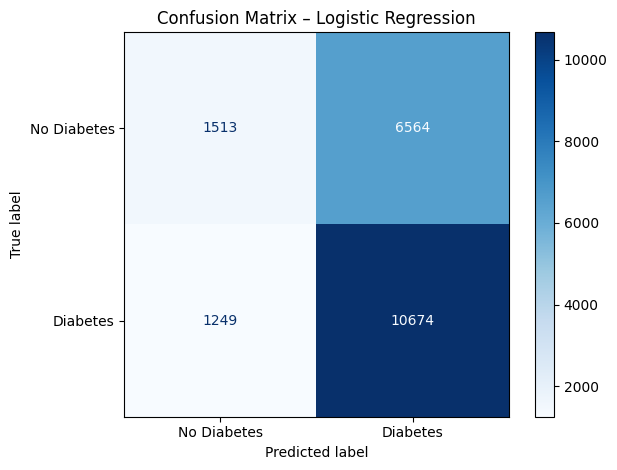

In [148]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix with academic-style colormap
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["No Diabetes", "Diabetes"]
)

fig, ax = plt.subplots()
disp.plot(ax=ax, cmap="Blues", colorbar=True)

plt.title("Confusion Matrix – Logistic Regression")
plt.tight_layout()

# Save figure
fig.savefig(FIGURES_DIR / "LR_confusion_matrix.png", dpi=300)
plt.show()

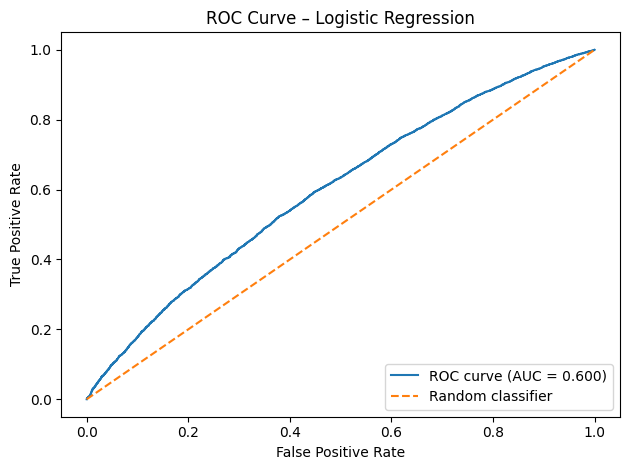

In [149]:
fig, ax = plt.subplots()

ax.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
ax.plot([0, 1], [0, 1], linestyle="--", label="Random classifier")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curve – Logistic Regression")
ax.legend(loc="lower right")

fig.tight_layout()
fig.savefig(FIGURES_DIR / "LR_ROC_curve.png", dpi=300, bbox_inches="tight")
plt.show()


- The ROC–AUC of approximately 0.60 indicates modest but meaningful discrimination, demonstrating that the model performs better than random classification in distinguishing individuals with and without diagnosed diabetes. While this level of discrimination is insufficient for definitive diagnosis, it is consistent with expectations for a model based solely on non-clinical, self-reported lifestyle and demographic information.

- The confusion matrix further shows a relatively high number of false positives, alongside non-negligible false negatives. In the context of diabetes risk assessment, this trade-off is acceptable and even desirable for a screening-oriented or pre-diagnostic model, where the primary objective is to identify individuals at elevated risk rather than to provide a final diagnosis. False positives can be resolved through subsequent clinical testing, whereas false negatives carry a higher public health cost due to missed opportunities for early intervention.

# Conclusion

Taken together, these evaluation results suggest that, although the model has limited predictive accuracy at the individual level, it successfully captures statistically significant and clinically relevant effects of modifiable lifestyle behaviors, particularly physical activity, diet quality, and sedentary behavior, on the odds of diabetes diagnosis. As such, the model is best interpreted as an initial risk stratification tool, suitable for informing preventive strategies and identifying candidates for further clinical assessment. Incorporating additional clinical and biological predictors—such as anthropometric measures, cardiovascular indicators, and glycaemic biomarkers identified in the EDA—is expected to substantially improve predictive performance in subsequent modeling stages.